## 回归预测x与y的关系-使用神经网络

神经网络(一种通过简单函数的组合来实现复杂函数的数学实体)是深度学习的核心。   
`PyTorch`中有一个专门用于神经网络的模块`torch.nn`，（Neural Network）`nn`模块包含创建各种神经网络结构所需的构建块。

上一篇中我们使用了线性模型，这一篇我们使用神经网络：  
- 使用一个线性模型：1个输入，16个输出
- 然后使用一个激活函数，这里我们使用`tanh`
- 再输入到另外一个线性模型中。16个输入，1个输出

> 第一个线性模型和激活层通常被称为隐藏层（他们的输出不是直接能观察到的，这个输出直接输入到后面的一层线性模型中了）。
> `torch.nn`中通过`nn.Sequential`容器来连接模型。


In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123456)

print("")

### 1. 我们先画一下tanh函数的图像

In [2]:
import math
math.tanh(-100), math.tanh(12)

(-1.0, 0.9999999999244973)

In [3]:
np.tanh(-100), np.tanh(12)

(-1.0, 0.9999999999244973)

In [4]:
# x中的点
x_line = np.linspace(-10,10,500)
y_line = np.tanh(x_line)

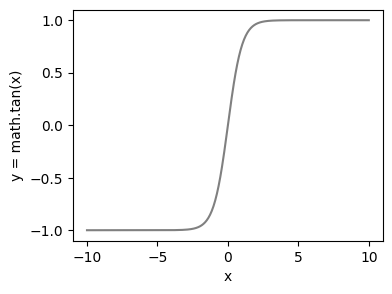

In [5]:
# 画图
fig = plt.figure(figsize=(4,3), dpi=100)
plt.xlabel("x")
plt.ylabel("y = math.tan(x)")
plt.plot(x_line, y_line, label="y = math.tan(x)", color="gray")
plt.show()

### 2. 组合一个简单网络
`nn.Sequential`是一个有序的容器，它包含一系列模块，并按照他们在构造函数中传递的顺序进行前向传播。    
这是一个非常方便的模块，允许我们快速的搭建一个由多个层组成的简单网络，这样组合的神经网络，不需要定义自己的`forward`方法。

In [6]:
model = nn.Sequential(
    # 张量输入大小是1，输出的张量大小是16
    nn.Linear(1, 16),  # 第一层
    nn.Tanh(),         # 第一层(隐藏层)的激活函数
    nn.Linear(16, 1),  # 输出层 16个输入，1个输出
)

In [7]:
model

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=1, bias=True)
)

In [8]:
# 查看模型的参数
for p in model.parameters():
    print(type(p), p.shape, p.numel())

<class 'torch.nn.parameter.Parameter'> torch.Size([16, 1]) 16
<class 'torch.nn.parameter.Parameter'> torch.Size([16]) 16
<class 'torch.nn.parameter.Parameter'> torch.Size([1, 16]) 16
<class 'torch.nn.parameter.Parameter'> torch.Size([1]) 1


In [9]:
# 查看模型的参数: name 和 params
for name, p in model.named_parameters():
    print(name, type(p), "\t", p.shape)

0.weight <class 'torch.nn.parameter.Parameter'> 	 torch.Size([16, 1])
0.bias <class 'torch.nn.parameter.Parameter'> 	 torch.Size([16])
2.weight <class 'torch.nn.parameter.Parameter'> 	 torch.Size([1, 16])
2.bias <class 'torch.nn.parameter.Parameter'> 	 torch.Size([1])


In [10]:
# 统计模型的参数个数
sum([p.numel() for p in model.parameters() if p.requires_grad])

49

### 3. 训练循环

#### 3.1 编写训练循环

In [11]:
def training_loop(epochs, model, optimizer, loss_function, train_source, train_real_value, print_step=10):
    for epoch in range(epochs):
        # 先对参数的梯段置零
        optimizer.zero_grad()

        # 正向传播：计算预测值
        predict = model(train_source)
        
        # 计算损失
        loss = loss_function(predict, train_real_value)
        
        # print(epoch, "loss is", loss)
        # 反向传播: 更新params的梯度
        loss.backward()
        
        # 不需要手动去修改params了，直接调用优化器的step()
        optimizer.step()
            
        # 输出日志信息
        if  epoch == 0 or (epoch + 1) % print_step == 0:
            print("第{}次训练, Loss is {:.2f}".format(epoch + 1, float(loss)))

#### 3.2 损失函数和优化器

In [12]:
# 查看model
model

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=1, bias=True)
)

In [13]:
# 优化器
learning_rate = 1e-3
optimizer = optim.SGD(
    model.parameters(),
    lr=learning_rate
)

# 损失函数
def loss_function(predict, real_value):
    squared_diffs = (predict - real_value)**2
    return squared_diffs.mean()

#### 3.3 执行训练循环


**准备训练数据：**

In [14]:
# x and y
x = [-6.0, -4.0, -1.2, -1.6, 1.0, 1.5, 2.3, 1.9, 3.3, 4.2, 5.0, 7.7, 8.2]
x = torch.tensor(x).unsqueeze(1)

y = torch.tensor([
    -36.8778, -26.4276, -19.5442, -20.2848, -10.5902, -13.0207, -10.1414, -9.3716,
    -4.7571,  -1.8561, 1.2260,  12.6646,  12.8662
]).unsqueeze(1)
print(x.shape, y.shape)

torch.Size([13, 1]) torch.Size([13, 1])


**执行训练：**

In [15]:
training_loop(
    epochs=20000,
    model=model,
    optimizer=optimizer,
    loss_function=loss_function,
    train_source=x,
    train_real_value=y,
    print_step=1000
)

第1次训练, Loss is 275.76
第1000次训练, Loss is 3.60
第2000次训练, Loss is 2.09
第3000次训练, Loss is 1.64
第4000次训练, Loss is 1.42
第5000次训练, Loss is 1.30
第6000次训练, Loss is 1.22
第7000次训练, Loss is 1.16
第8000次训练, Loss is 1.12
第9000次训练, Loss is 1.09
第10000次训练, Loss is 1.06
第11000次训练, Loss is 1.04
第12000次训练, Loss is 1.01
第13000次训练, Loss is 0.95
第14000次训练, Loss is 0.89
第15000次训练, Loss is 0.85
第16000次训练, Loss is 0.82
第17000次训练, Loss is 0.80
第18000次训练, Loss is 0.78
第19000次训练, Loss is 0.77
第20000次训练, Loss is 0.76


**查看一下我们模型调用后的输出值：**

In [16]:
# 模型计算出的预测值
model(x)

tensor([[-36.7782],
        [-26.5868],
        [-19.4120],
        [-20.2429],
        [-12.2612],
        [-11.1146],
        [ -9.0226],
        [-10.1243],
        [ -5.6757],
        [ -1.9590],
        [  1.6859],
        [ 12.0619],
        [ 13.3105]], grad_fn=<AddmmBackward0>)

In [17]:
# 真实的输出
y

tensor([[-36.8778],
        [-26.4276],
        [-19.5442],
        [-20.2848],
        [-10.5902],
        [-13.0207],
        [-10.1414],
        [ -9.3716],
        [ -4.7571],
        [ -1.8561],
        [  1.2260],
        [ 12.6646],
        [ 12.8662]])

#### 3.5 画图展示

In [18]:
# x中的点
x_line = np.linspace(-10,10,500, dtype=np.float32)

# y的点
# x_range = torch.arange(-10., 10.).unsqueeze(1)
x_range = torch.from_numpy(x_line).unsqueeze(1)
y_line = model(x_range).detach().numpy()

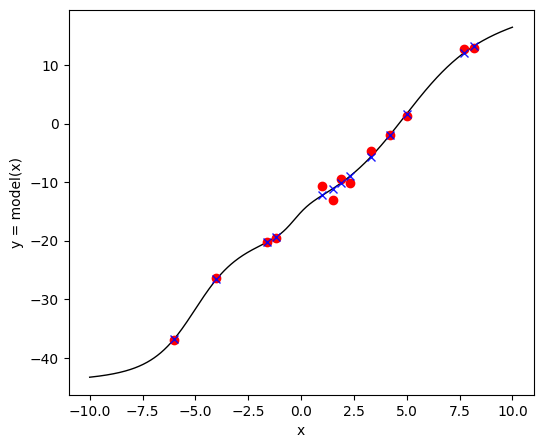

In [19]:
# 画图
fig = plt.figure(figsize=(6,5), dpi=100)
plt.xlabel("x")
plt.ylabel("y = model(x)")
plt.plot(x_line, y_line, label="y = model(x)", color="black", linewidth=1)
plt.plot(x.numpy(), y.numpy(), 'o', color="red")
plt.plot(x.numpy(), model(x).detach().numpy(), 'x', color="blue", alpha=0.9)
plt.show()